In [1]:
from dime import *
from config import load_config
import numpy as np
import matplotlib.pyplot as plt

/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
n_lat=180
n_lon=360
r_deg=10
lat_deg=-60
lon_deg=0
r1_deg=5
lat1_deg=0
lon1_deg=60

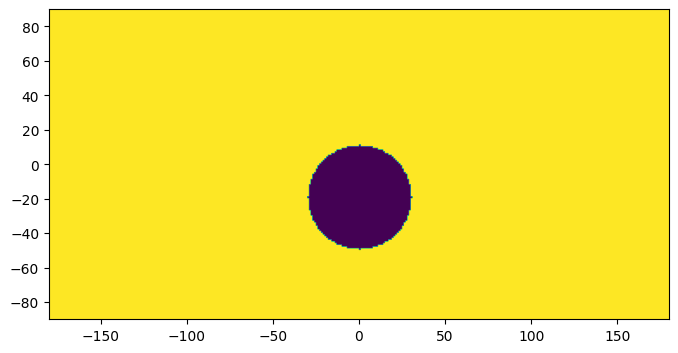

In [43]:
fakemap = np.ones((n_lat, n_lon))
x, y = np.meshgrid(np.linspace(-n_lon/2, n_lon/2-1, n_lon), np.linspace(-n_lat/2, n_lat/2-1, n_lat))
fakemap[np.sqrt((y-lat_deg)**2 + (x-lon_deg)**2) <= r_deg] = 0.9 # default spot at lon=0
plt.figure(figsize=(8,6))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90));

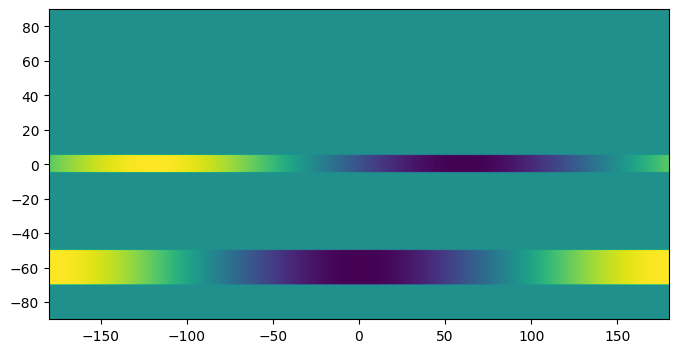

In [97]:
contrast = 0.8
amp = 1. - contrast
fakemap = np.ones((n_lat, n_lon))
band_ind = np.s_[90+lat_deg-r_deg:90+lat_deg+r_deg]
fakemap[band_ind] += amp * np.sin((x[band_ind]-lon_deg-90) * np.pi/180)
band1_ind = np.s_[90+lat1_deg-r1_deg:90+lat1_deg+r1_deg]
fakemap[band1_ind] += amp * np.sin((x[band1_ind]-lon1_deg-90) * np.pi/180)

plt.figure(figsize=(8,6))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90));

In [70]:
import paths
fakemap = str(paths.data / 'modelmaps/SPOT.png')

In [147]:
img = np.loadtxt(paths.data/'modelmaps/gcm.txt')

In [148]:
img = zoom(img, (180/img.shape[0], 360/img.shape[1]), mode='nearest')
img.shape

(180, 360)

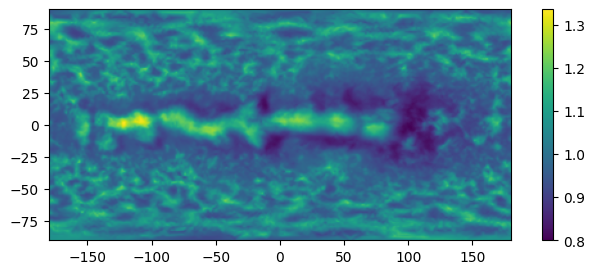

In [151]:
lon_deg = 100
img /= np.median(img)
diff = 1 - img
ampold = diff.max()
amp = 1 - contrast
diffnew = diff * amp / ampold
fakemap = 1 - diffnew
fakemap = np.roll(fakemap, shift=int(lon_deg), axis=1)
plt.figure(figsize=(8,3))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90))
plt.colorbar();

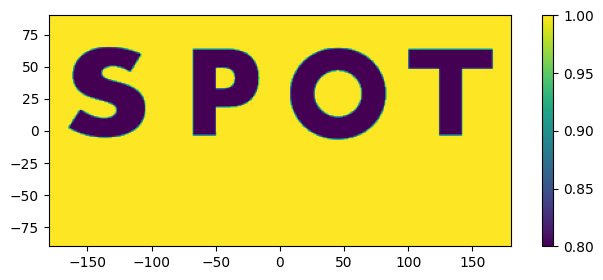

In [162]:
contrast = 0.8
amp=1-contrast
img = plt.imread(paths.data/'modelmaps/SPOT.png')
img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
img = zoom(img[::-1], (180/img.shape[0], 360/img.shape[1]), mode='nearest')
img /= np.median(img)
diff = 1. - img
diffnew = diff * amp / diff.max()
fakemap = 1. - diffnew
plt.figure(figsize=(8,3))
plt.imshow(fakemap, origin='lower', extent=(-180, 180, -90, 90))
plt.colorbar();

In [160]:
fakemap.max()

0.9999769234317623

In [158]:
img.min()

0.1333200069531798

In [1]:
import paths
import os
import numpy as np
from dime import DopplerImaging, load_data_from_pickle
from config import load_config
import matplotlib.pyplot as plt
from astropy.io import fits

instru = "IGRINS"
target = "W1049B"
band = "K"
savedir = f"{instru}_{band}_{target}"

params, goodchips, modelspec = load_config(instru, target, band)
model_datafile = paths.data/f'fitted/{instru}_{target}_{band}_{modelspec}.pickle'
#goodchips = [1,2,3,4]

wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips)
self = DopplerImaging(wav_nm, goodchips, params_dict=params)
self.load_data(observed, template, error)

/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/IGRINS_W1049B_K_t1500g1000f8.pickle.
observed: (14, 10, 1648)
template: (14, 10, 1648)
wav: (10, 1648)
nobs: 14, nchip: 10, npix: 1648
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.


/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)


In [2]:
self.make_lsd_profile(modelspec, shiftmods=True, shiftkerns=False, plot_lsd_profiles=False, plot_deviation_map=False)

chip 0


/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


chip 1
chip 2
chip 3
chip 4
chip 5
chip 15
chip 16
chip 17
chip 18


metric: -10679.52, chisq: 138.54, entropy: 5.37


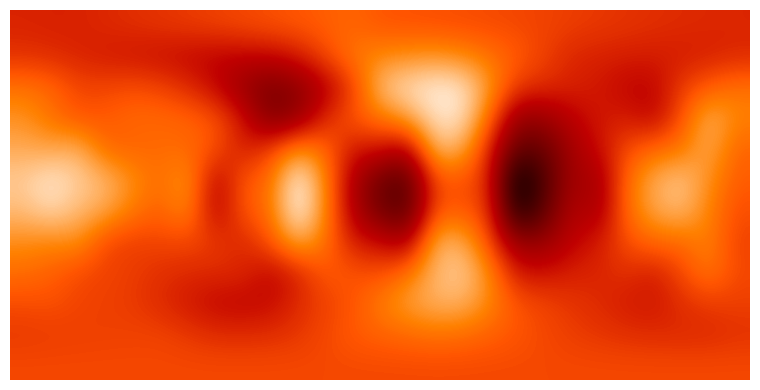

In [3]:
self.solve(create_obs_from_diff=True, solver='scipy')
self.plot_mecator_map()

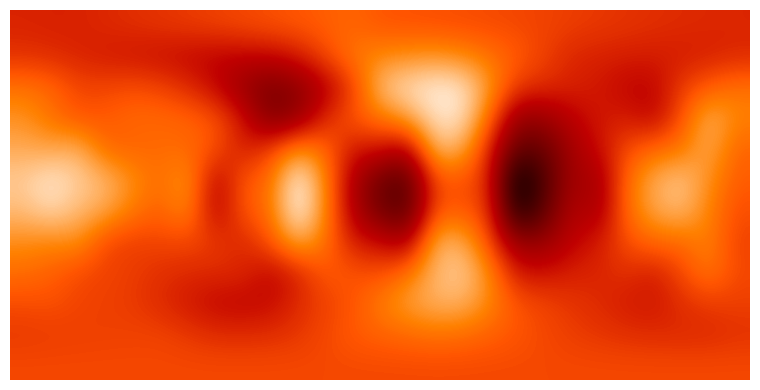

In [4]:
def fill_nan(data):
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data[bad_indexes] = interpolated
    return data

def plot_mecator_map(self, clevel=5, sigma=1, colormap=plt.cm.gist_heat, savedir=None):
    fig, ax = plt.subplots(figsize=(8,4))
    #plotmap = np.apply_along_axis(fill_nan, 0, self.bestparamgrid)
    plotmap = np.nan_to_num(self.bestparamgrid, nan=100.0)
    lon = np.linspace(-np.pi, np.pi, self.bestparamgrid.shape[1])
    lat = np.linspace(-np.pi/2., np.pi/2., self.bestparamgrid.shape[0])
    Lon, Lat = np.meshgrid(lon,lat)
    #im = ax.pcolormesh(Lon, Lat, plotmap, cmap=colormap, shading='gouraud')
        
    ax.imshow(plotmap, origin='lower', extent=(-180, 180, -90, 90), cmap=colormap, interpolation='bicubic')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.grid("off")
    plt.axis('off')
    for item in ax.spines.values():
        item.set_linewidth(1.2)
    plt.tight_layout()
    plt.savefig(f"{paths.figures/savedir}/mecator.png", bbox_inches='tight', pad_inches=0)
    fits.writeto(f"{paths.figures/savedir}/mecator.fits", self.bestparamgrid, overwrite=True)

plot_mecator_map(self, savedir=savedir)

In [34]:
f"{paths.figures/savedir}/test.png"

'/Users/xqchen/workspace/doppler-imaging-maxentropy/output/IGRINS_K_W1049B/test.png'

In [177]:
def plot_fit_results_2d(self, dev_only=True, savedir=None, figsize=(5,7), gap=0.02, lw=2):
    '''Plot the observed and best-fit LP series.

    Parameters
    ----------
        savedir: str
            Full path (include filename) to save the figure.
    '''
    obs_2d = np.reshape(self.observed_1d_sc, (self.nobs, self.nk))
    bestmodel_2d = np.reshape(self.model_observation, (self.nobs, self.nk))
    flatmodel_2d = np.reshape(self.flatmodel, (self.nobs, self.nk))

    cut = int((self.nk - 70) / 2 + 1.)
    plt.figure(figsize=figsize)
    for i in range(self.nobs):
        if dev_only:
            plt.plot(self.dv[cut:-cut], obs_2d[i][cut:-cut] - flatmodel_2d[i][cut:-cut] - gap*i, color='k', linewidth=lw, label="observed")
            plt.plot(self.dv[cut:-cut], bestmodel_2d[i][cut:-cut] - flatmodel_2d[i][cut:-cut] - gap*i, color='tab:orange', linewidth=lw, label="modelled")
            plt.plot(self.dv[cut:-cut], flatmodel_2d[i][cut:-cut] - flatmodel_2d[i][cut:-cut] - gap*i, '--', color='gray', linewidth=lw, label="flat map")
        else:
            plt.plot(self.dv[cut:-cut], obs_2d[i][cut:-cut] - gap*i, color='k', linewidth=lw, label="observed")
            plt.plot(self.dv[cut:-cut], bestmodel_2d[i][cut:-cut] - gap*i, color='tab:orange', linewidth=lw, label="modelled")
            plt.plot(self.dv[cut:-cut], flatmodel_2d[i][cut:-cut] - gap*i, '--', color='gray', linewidth=lw, label="flat map")
        if i==0:
            plt.legend(loc=2, bbox_to_anchor=(1.05, 1.))
    plt.xlabel("velocity (km/s)")

    if savedir is not None:
        plt.savefig(savedir, bbox_inches="tight", dpi=150, transparent=True)

In [186]:
def plot_fit_results_1d(self, savedir=None, figsize=(18,3), gap=0.02, lw=2):
    '''Plot the observed and best-fit LP series.

    Parameters
    ----------
        savedir: str
            Full path (include filename) to save the figure.
    '''
    plt.figure(figsize=figsize)
    plt.plot(self.observed_1d_sc, '.', color='k', linewidth=lw, label="Observed")
    plt.plot(self.model_observation, color='orangered', linewidth=lw, label="Modelled", alpha=0.6)
    #plt.plot(self.observed_1d_sc - self.model_observation + 0.95, '-', color='gray', linewidth=lw, label="residual")
    #plt.plot(self.flatmodel, '--', color='gray', linewidth=lw, label="flat map")
    plt.yticks(np.arange(0.95, 1.0, 0.01))
    plt.xticks([self.nk/2 + self.nk*i for i in range(self.nobs)], [f"{i+1}" for i in range(self.nobs)])
    plt.xlabel("$\it{nobs}$")
    plt.xlim(-10, self.nk*self.nobs+10)
    #plt.ylim(0.93, 1.01)
    plt.text(1.01, 0.5,  #self.nk*self.nobs+30, 0.975, 
            f"Q  = {self.metric:.2f} \n$\chi ^2$ = {self.chisq:.2f} \nS  = {self.entropy:.2f}",
            verticalalignment='top', linespacing=1.2, transform=plt.gca().transAxes)
    plt.legend(loc=2, bbox_to_anchor=(1., 1.))

    if savedir is not None:
        plt.savefig(savedir, bbox_inches="tight", dpi=150, transparent=True)

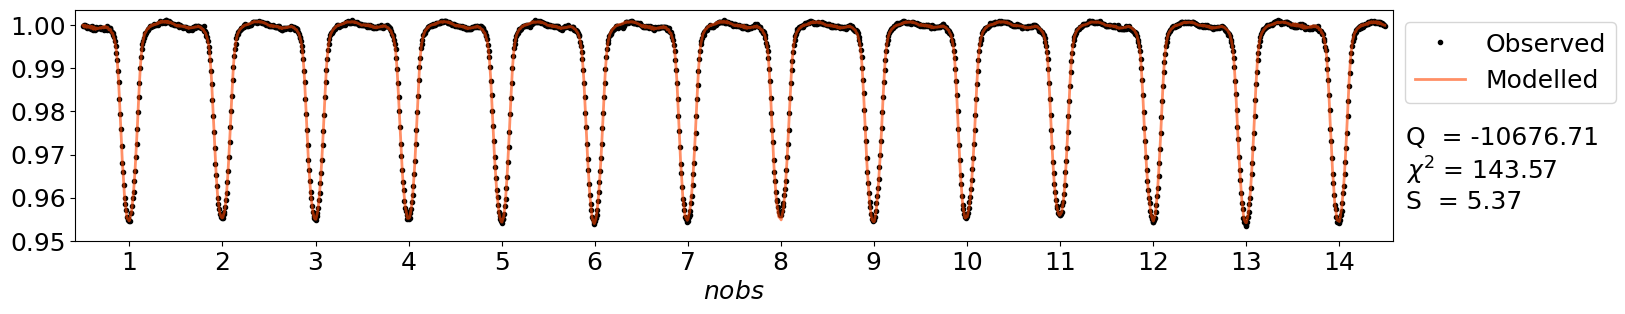

In [187]:
plot_fit_results_1d(self, figsize=(17,3))

Text(0.5, 1.0, 'Observed and best-fit line profiles')

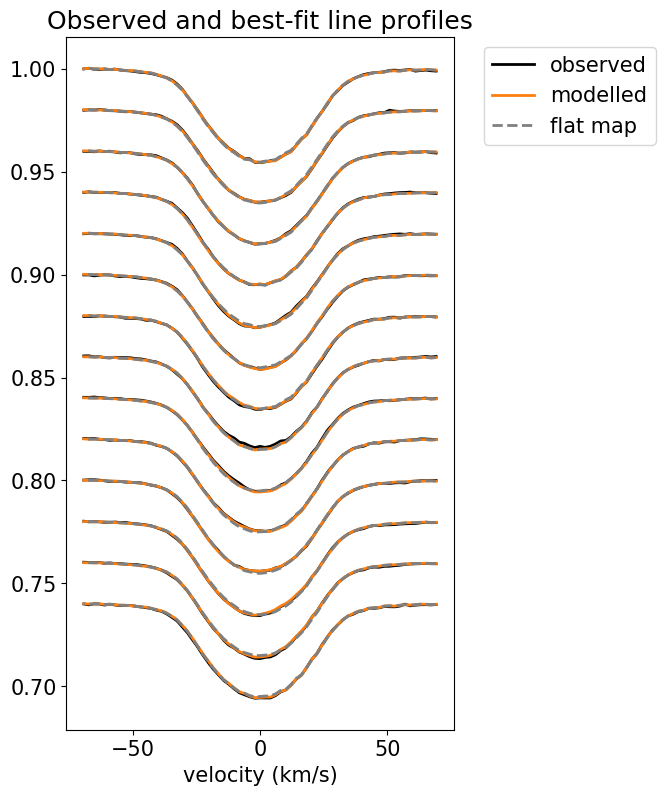

In [178]:
plt.rcParams.update({'font.size': 15})
plot_fit_results_2d(self,figsize=(5,9), gap=0.02, dev_only=False)
plt.title("Observed and best-fit line profiles")

In [179]:
obs_2d = np.reshape(self.observed_1d_sc, (self.nobs, self.nk))
flatmodel_2d = np.reshape(self.flatmodel, (self.nobs, self.nk))
bestmodel_2d = np.reshape(self.model_observation, (self.nobs, self.nk))

In [180]:
def plot_deviation_map(self, line_profiles, savedir=None, colorbar=False, cmap='YlOrBr', 
                        vmax=0.003, figsize=(6,4), aspect=30, lw=1, dpi=150):
    '''Plot order-averaged deviation map.
    A darker deviation pattern means a surface feature fainter than the background.

    Parameters
    ----------
        savedir: str
            Full path (include filename) to save the figure.
        meanby: str
            Method to calculate the mean deviation: 
            'median': take the median of the deviation over all orders
            'median_each': take the median LP for each order, then take the deviation from uniform LP
            'mean': take the mean of the deviation over all orders
    '''
    plt.rcParams.update({'font.size': 18})
    ratio = 1.3 if self.nobs < 10 else 0.7

    #mean_dev = np.array([line_profiles[t] - timeav_profiles for t in range(self.nobs)])
    mean_dev = line_profiles
    #plt.figure(figsize=figsize)
    if vmax is not None:
        plt.imshow(mean_dev, 
            extent=(self.dv.max(), self.dv.min(), self.timestamps[-1], 0),
            aspect=int(ratio * aspect),
            cmap=cmap,
            vmin=-vmax, vmax=vmax) # positive diff means dark spot
    else:
        plt.imshow(mean_dev, 
            extent=(self.dv.max(), self.dv.min(), self.timestamps[-1], 0),
            aspect=int(ratio * aspect),
            cmap=cmap)
    cut = self.nk - 70 if self.nk > 70 else 0
    plt.xlim(self.dv.min() + cut, self.dv.max() - cut),
    plt.xlabel("velocity (km/s)")
    plt.xticks([-50, -25, 0, 25, 50])
    plt.ylabel("Elapsed time (h)")
    plt.yticks(np.unique([int(i) for i in self.timestamps]))
    plt.vlines(x=self.vsini, ymin=0, ymax=self.timestamps[-1], colors="k", linestyles="dashed", linewidth=lw)
    plt.vlines(x=-self.vsini, ymin=0, ymax=self.timestamps[-1], colors="k", linestyles="dashed", linewidth=lw)
    if colorbar:
        cb = plt.colorbar(fraction=0.06, pad=0.28, aspect=15, orientation="horizontal", label="%")
        cb_ticks = cb.ax.get_xticks()
        cb.ax.set_xticklabels([f"{t*100:.1f}" for t in cb_ticks])
        cb.ax.tick_params()
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(savedir, bbox_inches="tight", dpi=150, transparent=True)

/var/folders/jm/dmx123p56254c5gy18wgtyh00000gn/T/ipykernel_38359/401260250.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


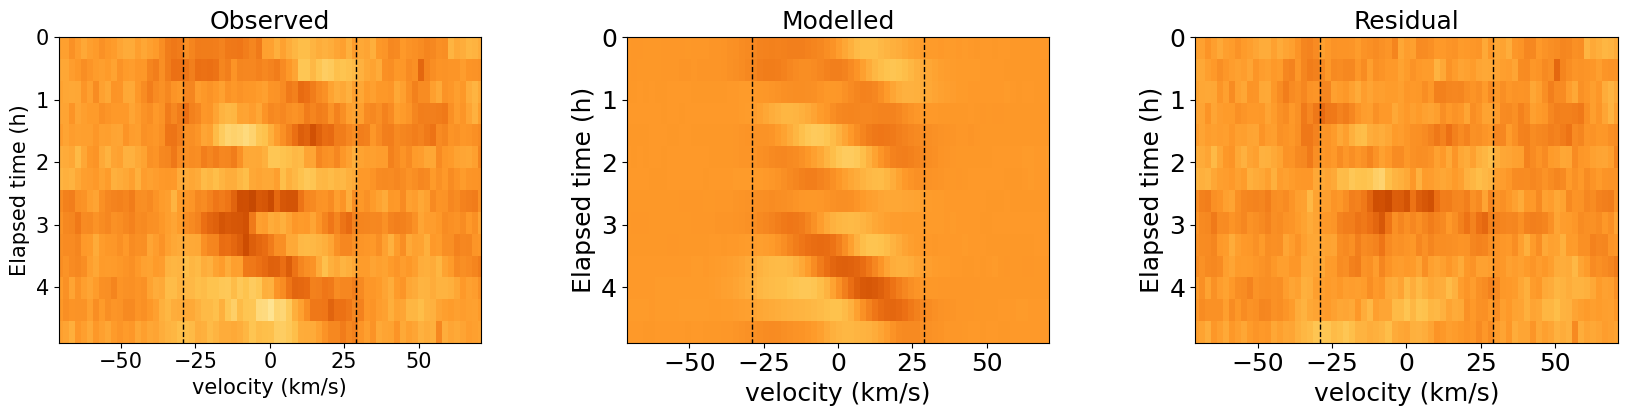

In [181]:
plt.figure(figsize=(18,4.5))
cmap='YlOrBr'
sz=18
dev_signal = obs_2d
dev_noise = abs(obs_2d - bestmodel_2d)
dev_snr = dev_signal / dev_noise
plt.subplot(131)
plot_deviation_map(self, obs_2d - flatmodel_2d, cmap=cmap)
plt.title("Observed", fontsize=sz)
plt.subplot(132)
plot_deviation_map(self, bestmodel_2d - flatmodel_2d, cmap=cmap)
plt.title("Modelled", fontsize=sz)
plt.subplot(133)
plot_deviation_map(self, obs_2d - bestmodel_2d, cmap=cmap)
plt.title("Residual", fontsize=sz);

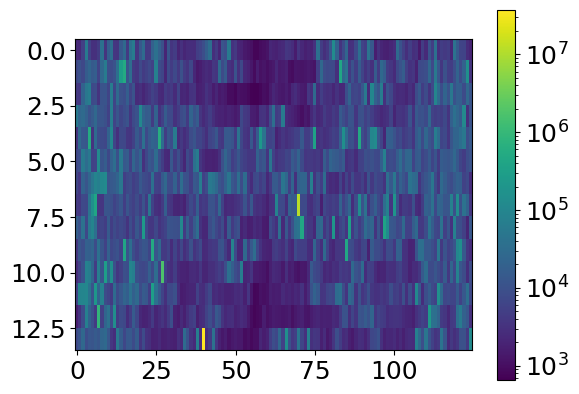

In [39]:
from matplotlib.colors import LogNorm
plt.imshow(dev_snr[:, ::-1], norm=LogNorm(), aspect=7)
plt.colorbar()

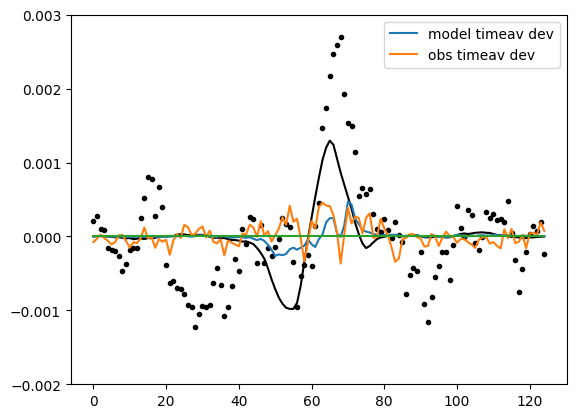

In [27]:
t=9
plt.plot(bestmodel_2d[t]-flatmodel_2d[t], color='k')
plt.plot(obs_2d[t]-flatmodel_2d[t], '.', color='k')
plt.plot(np.median(bestmodel_2d-flatmodel_2d, axis=0), label='model timeav dev')
plt.plot(np.median(obs_2d-flatmodel_2d, axis=0), label='obs timeav dev')
plt.plot(np.median(flatmodel_2d-flatmodel_2d, axis=0))
plt.ylim(-0.002, 0.003)
plt.legend()

Text(0.5, 13.52222222222222, '')

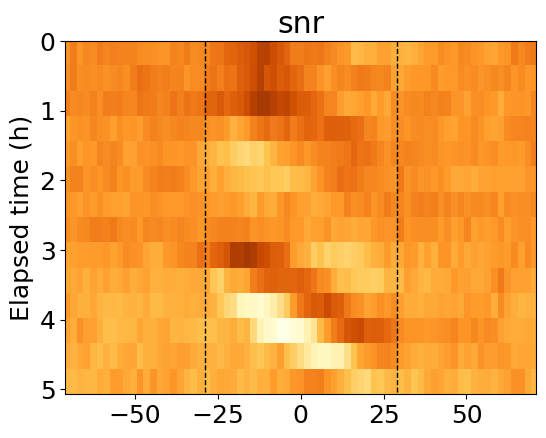

In [14]:
dev_signal = obs_2d
dev_noise = obs_2d - bestmodel_2d
dev_snr = dev_signal / dev_noise
plot_deviation_map(self, obs_2d-flatmodel_2d, aspect=30)
plt.title("snr")
plt.xlabel("")
#plt.text(20,0.5,"observed", fontsize=20)

Text(0.5, 21.138910913230106, '')

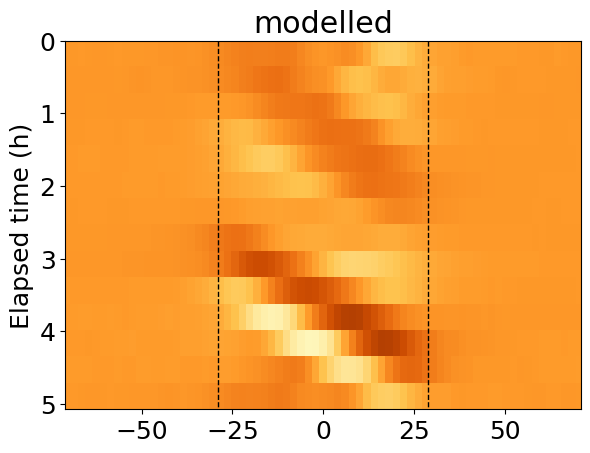

In [262]:
plot_deviation_map(self, bestmodel_2d-flatmodel_2d)
#plt.text(20,0.5,"modelled", fontsize=20)
plt.title("modelled")
plt.xlabel("")

Text(0.5, 1.0, 'residual')

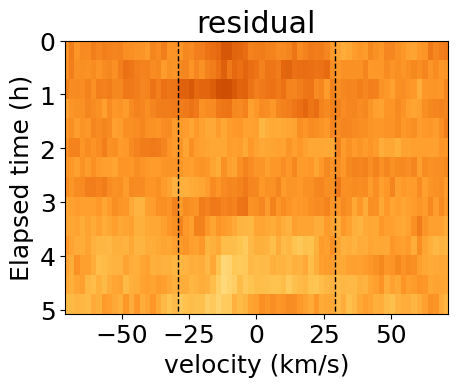

In [74]:
plot_deviation_map(self, obs_2d-bestmodel_2d)
#plt.text(30,0.5,"residual", fontsize=20)
plt.title("residual")

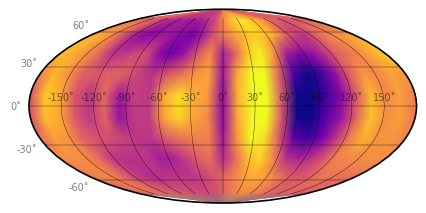

In [17]:
self.plot_mollweide_map(vmin=85, vmax=110)

In [478]:
import glob
from astropy.io import fits
homedir = os.path.expanduser('~')
target = 'W1049B'
band = 'H'
filelist = sorted(glob.glob(
            f'{homedir}/uoedrive/data/IGRINS_{target}/SDC{band}*_1f.spec.fits'
        ))
fluxes = []
wls = []
sns = []
for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'
    snname = filename.split('_1f')[0]+'_1f.sn.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    sn = fits.getdata(snname)

    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    sn = sn[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl) 
    sns.append(sn)
fluxes = np.array(fluxes)
wls = np.array(wls)
fluxes= fluxes[:,1:,:]
wls = wls[:,1:,:]

In [479]:
fluxes_sum = np.sum(fluxes, axis=-1)
for c in range(fluxes_sum.shape[1]):
    fluxes_sum[:,c] /= np.median(fluxes_sum[:,c])
wls_av = np.median(wls, axis=0)

In [480]:
# get timestamps
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS_W1049B_20200211_full/SDCK_2020*.spec_a0v.fits'))
times=[]
for filename in filelist:
    hdu = fits.open(filename)
    spec_a0v = hdu[0].data
    wave_a0v = hdu[1].data
    jd = hdu[0].header["JD-OBS"]
    times.append((jd-int(jd))*24)

times = np.array(times)
times = times - times[0]
times = np.array(times)

In [475]:
goodchips =[0, 1, 2, 3, 4, 5, 16, 17, 18, 19]

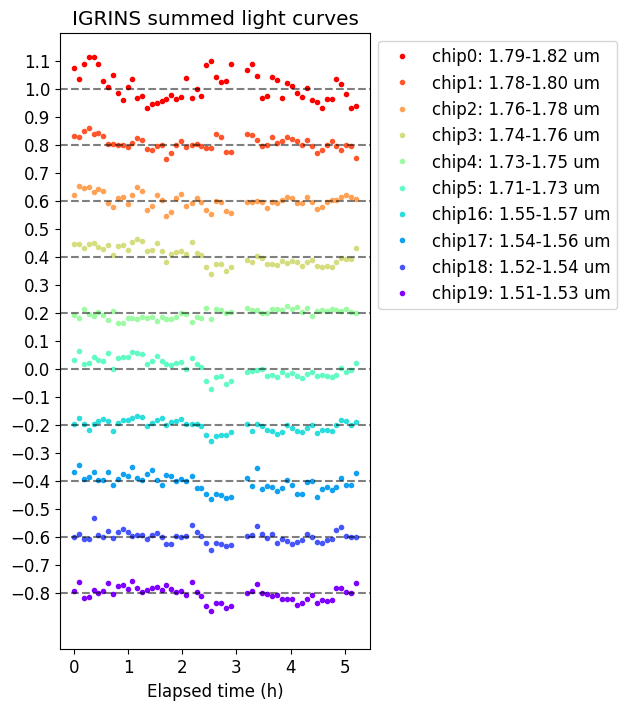

In [481]:
plt.rcParams.update({'font.size': 12})
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(goodchips)))
gap=0.2
plt.figure(figsize=(4,8))
for i, c in enumerate(goodchips):
    plt.plot(times, fluxes_sum[:,c] - gap*i, '.', color=colors[i], 
             label=f"chip{c}: {wls_av[c].min():.2f}-{wls_av[c].max():.2f} um")
    plt.axhline(1-gap*i, color="k", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')
plt.yticks(np.arange(-0.8, 1.2, 0.1))
plt.ylim(-1., 1.2)
plt.xlabel("Elapsed time (h)")
plt.title("IGRINS summed light curves");

In [180]:
instru = "IGRINS"
target = "W1049B"
band = "K"
savedir = f"{instru}_{band}_{target}"

params, goodchips, modelspec = load_config(instru, target, band)
model_datafile = paths.data/f'fitted/{instru}_{target}_{band}_{modelspec}.pickle'
#goodchips = [1,2,3,4]

wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips)
wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips)
self = DopplerImaging(wav_nm, goodchips, params_dict=params)
self.load_data(observed, template, error)
self.make_lsd_profile(modelspec, shiftmods=True, shiftkerns=False, plot_lsd_profiles=False, plot_deviation_map=False)

Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/IGRINS_W1049B_K_t1500g1000f8.pickle.
observed: (14, 10, 1648)
template: (14, 10, 1648)
wav: (10, 1648)
Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/IGRINS_W1049B_K_t1500g1000f8.pickle.
observed: (14, 10, 1648)
template: (14, 10, 1648)
wav: (10, 1648)
nobs: 14, nchip: 10, npix: 1648
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.
chip 0


/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:414: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:414: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


chip 1
chip 2
chip 3
chip 4
chip 5
chip 15
chip 16
chip 17
chip 18


signal:0.49, noise:0.04, snr:11.05


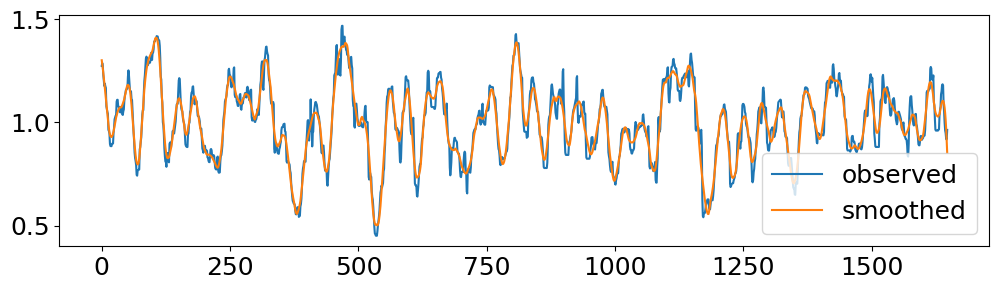

In [166]:
c=8
smoothed = savgol_filter(observed, 31, 3)
resid = observed - smoothed
err_pix = np.array([np.abs(resid[0,c,pix] - np.median(resid, axis=2)) for pix in range(observed.shape[2])]) # error of each pixel in LP by MAD
err_pix_linecen = err_pix
err_LP = 1.4826 * np.median(err_pix_linecen, axis=0) # error of each LP (at each t and chip)

signal = 1 - smoothed.min(axis=2).mean(axis=0) # signal = line depth
noise = np.median(err_LP, axis=0) # mean error of a chip
snr_LPs = signal/noise # S/N of LP of each chip
plt.figure(figsize=(12,3))
plt.plot(observed[0][c], label="observed")
plt.plot(smoothed[0][c], label="smoothed")
plt.legend()
print(f"signal:{signal[c]:.2f}, noise:{noise[c]:.2f}, snr:{snr_LPs[c]:.2f}")

signal:0.19, noise:0.05, snr:4.18


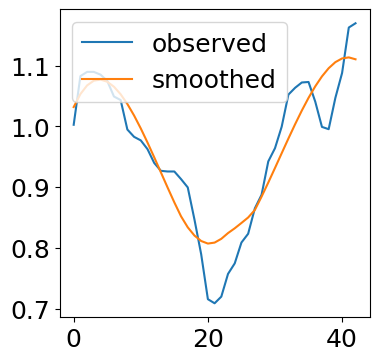

In [205]:
line1 = observed[0,5,1270:1360]
line2 = observed[0,3,1050:1200]
line3 = observed[0,8,630:760]
line4 = observed[0,8,1247:1290]
line = line4
smoothed = savgol_filter(line, 31, 3)
resid = line - smoothed
err_pix = np.array([np.abs(resid[pix] - np.median(resid)) for pix in range(len(resid))]) # error of each pixel in LP by MAD
err_pix_linecen = err_pix
err_LP = 1.4826 * np.median(err_pix_linecen, axis=0) # error of each LP (at each t and chip)

signal = 1 - smoothed.min() # signal = line depth
noise = err_LP # mean error of a chip
snr_LPs = signal/noise # S/N of LP of each chip
plt.figure(figsize=(4,4))
plt.plot(line, label="observed")
plt.plot(smoothed, label="smoothed")
plt.legend()
print(f"signal:{signal:.2f}, noise:{noise:.2f}, snr:{snr_LPs:.2f}")

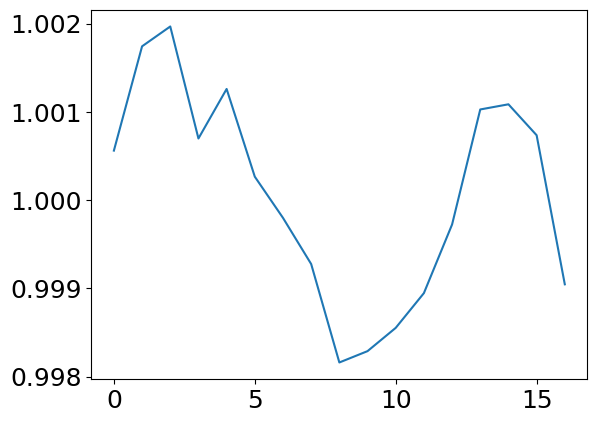

In [206]:
plt.plot(self.obskerns_norm[0,5][int(self.nk/2-80):int(self.nk/2+80)])

In [1]:
import ELL_map_class as ELL_map

In [11]:
inc = 30
inc_ = (90 - inc) * np.pi / 180
this_map = ELL_map.Map(nlat=self.nlat, nlon=self.nlon, type='eqarea', inc=inc_)

/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:227: RuntimeWarning: divide by zero encountered in double_scalars
  if visible_corners[1,ii]/newy < 0:


In [156]:
import paths
import os
import numpy as np
from dime import DopplerImaging, load_data_from_pickle
from config import load_config
import matplotlib.pyplot as plt

instru = "IGRINS"
target = "W1049B"
band = "K"
savedir = f"{instru}_{band}_{target}"
params['nlat'] = 20
params['nlon'] = 40

params, goodchips, modelspec = load_config(instru, target, band)
model_datafile = paths.data/f'fitted/{instru}_{target}_{band}_{modelspec}.pickle'
#goodchips = [1,2,3,4]

wav_nm, template, observed, error = load_data_from_pickle(model_datafile, goodchips)
self = DopplerImaging(wav_nm, goodchips, params_dict=params)
self.load_data(observed, template, error)

Data loaded from file /Users/xqchen/workspace/doppler-imaging-maxentropy/data/fitted/IGRINS_W1049B_K_t1500g1000f8.pickle.
observed: (14, 10, 1648)
template: (14, 10, 1648)
wav: (10, 1648)
nobs: 14, nchip: 10, npix: 1648
Created equa-area grid of 216 cells, in 12 latitude grids with [ 6 12 17 21 25 27 27 25 21 17 12  6] lontitude cells.


/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)
/Users/xqchen/workspace/doppler-imaging-maxentropy/src/ELL_map_class.py:226: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1. - np.tan(inc)**2 / np.tan(self.corners_latlon[0,ii])**2)


In [38]:
import pickle
with open(model_datafile, "rb") as f:
        data = pickle.load(f, encoding="latin1")

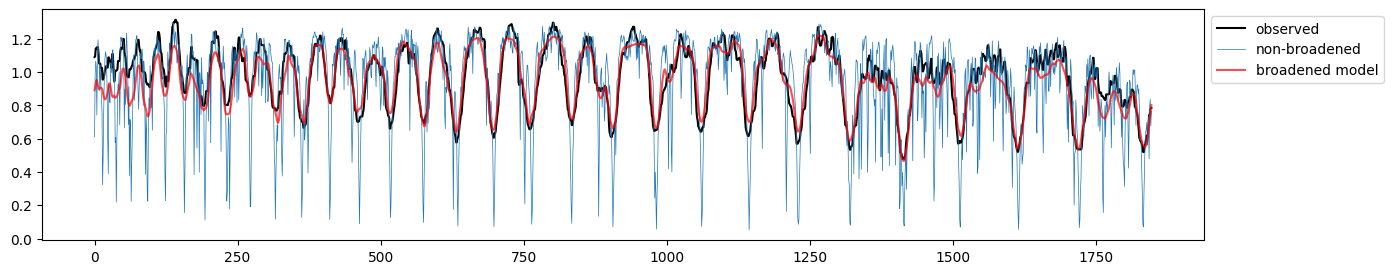

In [94]:
t=0
chip=5
plt.figure(figsize=(15,3))
plt.plot(data['fobs0'][t, chip], "k", label="observed")
plt.plot(data['chipmodnobroad'][t, chip], "tab:blue", linewidth=0.5, alpha=1,label="non-broadened")
plt.plot(data['chipmods'][t, chip], "r", alpha=0.7, label="broadened model")
plt.legend(bbox_to_anchor=(1., 1), loc='upper left')

In [157]:
self.make_lsd_profile(modelspec, shiftmods=True, shiftkerns=False, plot_lsd_profiles=False, plot_deviation_map=False)

chip 0


/Users/xqchen/workspace/doppler-imaging-maxentropy/venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


chip 1
chip 2
chip 3
chip 4
chip 5
chip 15
chip 16
chip 17
chip 18


In [158]:
self.solve(create_obs_from_diff=False, solver='scipy')
obs_2d = np.reshape(self.observed_1d_sc, (self.nobs, self.nk))
flatmodel_2d = np.reshape(self.flatmodel, (self.nobs, self.nk))
bestmodel_2d = np.reshape(self.model_observation, (self.nobs, self.nk))

metric: -9927.72, chisq: 1392.77, entropy: 5.31


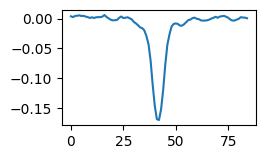

In [134]:
plt.figure(figsize=(2.5,1.5))
from scipy.signal import savgol_filter
plt.plot(savgol_filter(-self.modkerns[t,chip], 9, 3)[20:-20])

In [147]:
bestmodel_2d.shape

(14, 125)

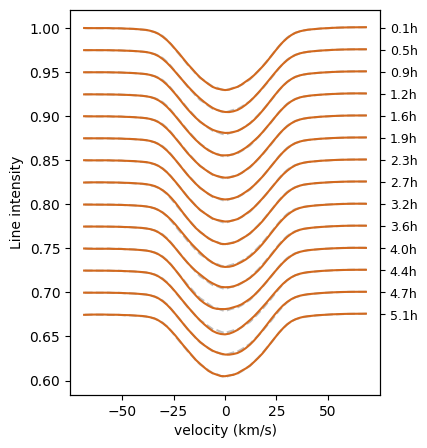

In [166]:
gap=0.025
line_profiles = bestmodel_2d
colors = [plt.cm.gnuplot_r(x) for x in np.linspace(0, 1, self.nobs+4)]
fig, ax = plt.subplots(figsize=(4, 5))
cut = int((self.nk - 70) / 2 + 1.)
for t in range(self.nobs):
    ax.plot(self.dv[cut:-cut], line_profiles.mean(axis=0)[cut:-cut] - gap*t, "--", color="gray", alpha=0.5)
    ax.plot(self.dv[cut:-cut], savgol_filter(line_profiles[t][cut:-cut], 11, 3) - gap*t, color='chocolate')
ax.set_xlabel("velocity (km/s)")
ax.set_xticks([-50, -25, 0, 25, 50])
ax.set_ylabel("Line intensity")
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ybound())
ax2.set_yticks([1 - gap*t for t in range(self.nobs)], labels=[f"{t:.1f}h" for t in self.timestamps], fontsize=9);